https://arxiv.org/abs/1704.03338

In [1]:
import os
os.environ["OPENBLAS_NUM_THREADS"] = '1'
os.environ["MKL_NUM_THREADS"] = '1'
os.environ["VECLIB_MAXIMUM_THREADS"] = '1'
os.environ["NUMEXPR_NUM_THREADS"] = '1'
os.environ['OMP_NUM_THREADS'] = '1'
os.environ['NPROC'] = '1'
os.environ['JAX_ENABLE_X64'] = 'True'
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

import numpy as np
import matplotlib.pyplot as plt
from corner import corner

import jax
import jax.numpy as jnp
import numpyro

## bimodal Gaussian

In [2]:
def target_potential(x):
    return -jnp.log(
        + 0.5 * jax.scipy.stats.norm.pdf(x, -5, 1)
        + 0.5 * jax.scipy.stats.norm.pdf(x, 5, 1)
    )

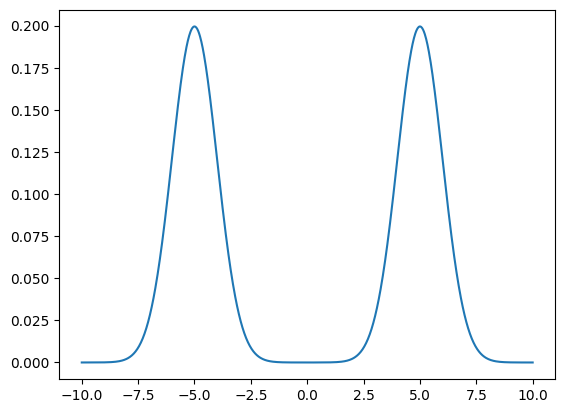

In [3]:
x = jnp.linspace(-10, 10, 1_000)
y = jnp.exp(-target_potential(x))
plt.plot(x, y);

#### naive HMC

In [5]:
nuts = numpyro.infer.NUTS(potential_fn = target_potential)
mcmc = numpyro.infer.MCMC(nuts, num_warmup = 10_000, num_samples = 10_000)
mcmc.run(jax.random.key(0), init_params = 5.)

sample: 100%|█████████████████████| 20000/20000 [00:22<00:00, 882.23it/s, 3 steps of size 1.09e+00. acc. prob=0.91]


In [6]:
mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
   Param:0      5.01      1.00      5.02      3.37      6.67   3785.32      1.00

Number of divergences: 0


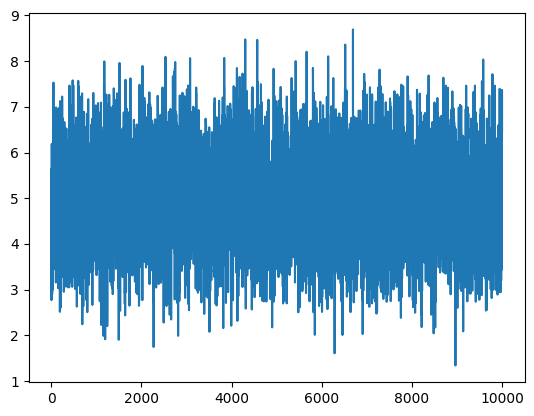

In [7]:
plt.plot(mcmc.get_samples());

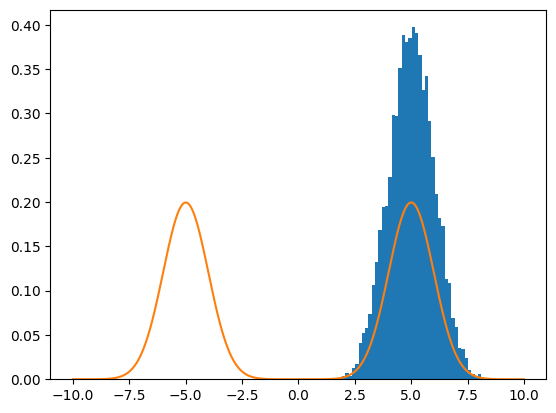

In [9]:
plt.hist(mcmc.get_samples(), bins = 50, density = True)
plt.plot(x, y);

#### CT-HMC

In [10]:
def beta(u):
    return jax.nn.sigmoid(u)

# uniform(-10, 10)
def base_potential(x):
    return -jnp.where(
        (-10 < x) * (x < 10),
        jnp.log(1 / (10 - -10)),
        -jnp.inf,
    )

def joint_potential(xu):
    x, u = xu
    ln_Z = 0
    b = beta(u)
    db_du = b * (1 - b)
    return b * (target_potential(x) + ln_Z) + (1 - b) * base_potential(x) - jnp.log(db_du)

def conditional(x, b):
    ln_Z = 0
    delta = target_potential(x) + ln_Z - base_potential(x)
    return jnp.exp(-b * delta) * delta / (1 - jnp.exp(-delta))

In [12]:
nuts = numpyro.infer.NUTS(potential_fn = joint_potential)
mcmc = numpyro.infer.MCMC(nuts, num_warmup = 10_000, num_samples = 10_000)
mcmc.run(jax.random.key(3), init_params = (5., 0.))

sample: 100%|█████████████████████| 20000/20000 [00:36<00:00, 547.50it/s, 7 steps of size 2.88e-01. acc. prob=0.88]


In [13]:
mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
   Param:0      0.67      5.25      3.08     -7.12      7.17    229.08      1.00
   Param:1     -0.03      1.93      0.03     -3.08      3.15   1954.79      1.00

Number of divergences: 622


In [19]:
z, u = mcmc.get_samples(group_by_chain = False)
weights = conditional(z, 1)
evidence = weights.sum() / conditional(z, 0).sum()
evidence

Array(0.92973193, dtype=float64)

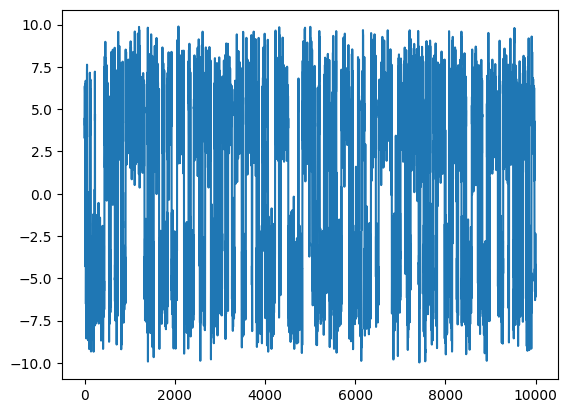

In [20]:
plt.plot(z);

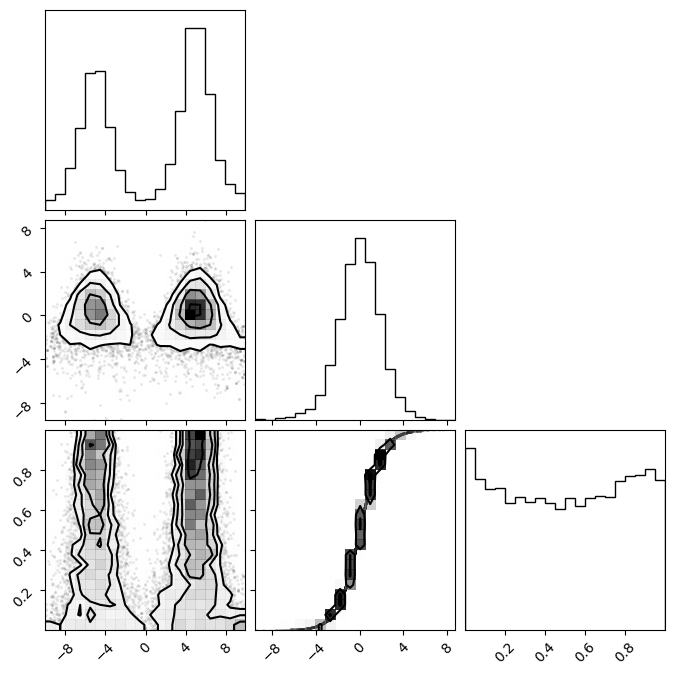

In [21]:
fig = corner(np.transpose([z, u, beta(u)]));

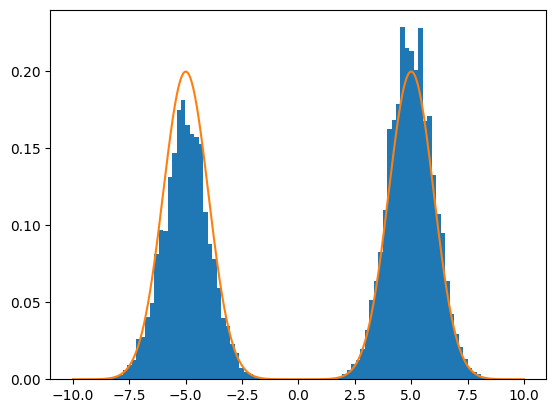

In [22]:
plt.hist(z, bins = 100, density = True, weights = weights)
plt.plot(x, y);

## bivariate GMM

In [23]:
locs = jnp.linspace(-15, 15, 5)
grid = jnp.array(jnp.meshgrid(locs, locs)).reshape(2, -1).T
components = numpyro.distributions.Normal(grid).to_event(1)
mixing = numpyro.distributions.Categorical(jnp.ones(25))
mixture = numpyro.distributions.Mixture(mixing, components)

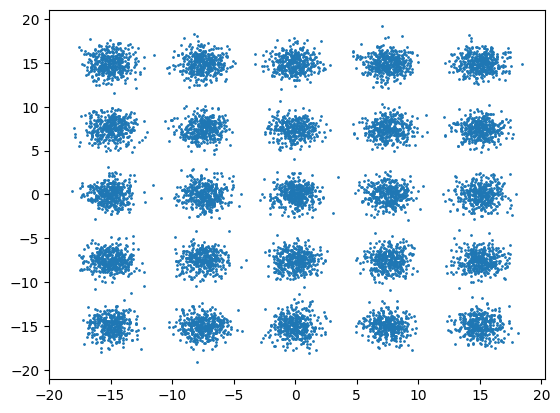

In [25]:
samples = mixture.sample(jax.random.key(0), (10_000,))
plt.scatter(*samples.T, s = 1);

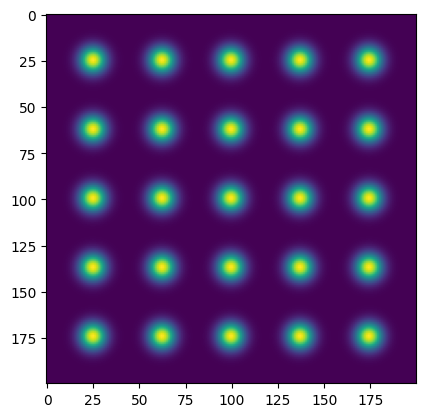

In [26]:
x = jnp.linspace(-20, 20, 200)
xx = jnp.array(jnp.meshgrid(x, x)).reshape(2, -1).T
lp = mixture.log_prob(xx).reshape(x.size, x.size)
plt.imshow(jnp.exp(lp));

In [28]:
def target_potential(x):
    return -mixture.log_prob(x)

#### naive HMC

In [30]:
nuts = numpyro.infer.NUTS(potential_fn = target_potential)
mcmc = numpyro.infer.MCMC(nuts, num_warmup = 10_000, num_samples = 10_000)
mcmc.run(jax.random.key(1), init_params = jnp.zeros(2))

sample: 100%|█████████████████████| 20000/20000 [00:29<00:00, 681.57it/s, 3 steps of size 1.27e-01. acc. prob=0.91]


In [31]:
mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
Param:0[0]     -4.86      9.79     -1.49    -16.88      8.44      8.92      1.03
Param:0[1]     -4.69     11.15     -7.89    -16.60     14.74     11.00      1.08

Number of divergences: 0


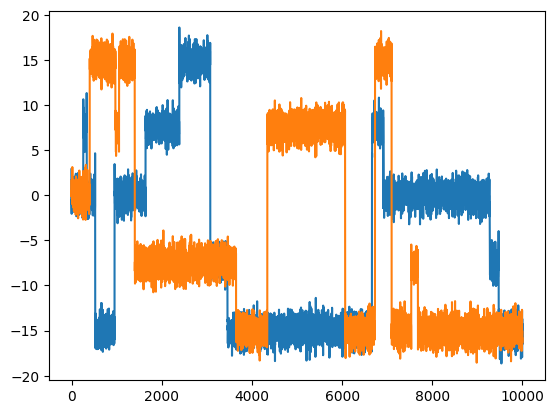

In [32]:
plt.plot(mcmc.get_samples());

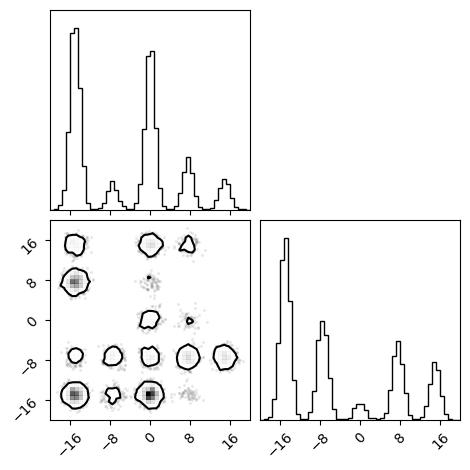

In [33]:
corner(
    np.array(mcmc.get_samples()),
    range = [[-20, 20]] * 2,
    bins = 50,
    levels = (0.9,),
);

#### CT-HMC

In [34]:
def beta(u):
    return jax.nn.sigmoid(u)

# uniform(-20, 20) X uniform(-20, 20)
def base_potential(x):
    return -jnp.where(
        (-20 < x).all() * (x < 20).all(),
        jnp.log(1 / (20 - -20)**2),
        -jnp.inf,
    )

def joint_potential(xu):
    x, u = xu
    ln_Z = 0
    b = beta(u)
    db_du = b * (1 - b)
    return b * (target_potential(x) + ln_Z) + (1 - b) * base_potential(x) - jnp.log(db_du)

def conditional(x, b):
    ln_Z = 0.0
    delta = target_potential(x) + ln_Z - base_potential(x)
    return jnp.exp(-b * delta) * delta / (1 - jnp.exp(-delta))

In [35]:
nuts = numpyro.infer.NUTS(potential_fn = joint_potential)
mcmc = numpyro.infer.MCMC(nuts, num_warmup = 10_000, num_samples = 10_000)
mcmc.run(jax.random.key(1), init_params = (jnp.zeros(2), 0.))

sample: 100%|█████████████████████| 20000/20000 [01:02<00:00, 318.69it/s, 7 steps of size 7.66e-02. acc. prob=0.94]


In [36]:
mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
Param:0[0]      0.32     10.93      0.18    -16.13     16.09    205.69      1.00
Param:0[1]     -0.95     10.70     -0.94    -16.08     16.07    254.43      1.00
   Param:1     -0.05      1.92     -0.01     -3.17      3.06   1562.95      1.00

Number of divergences: 952


In [37]:
z, u = mcmc.get_samples(group_by_chain = False)
weights = conditional(z, 1)
evidence = weights.sum() / conditional(z, 0).sum()
evidence

Array(0.97509186, dtype=float64)

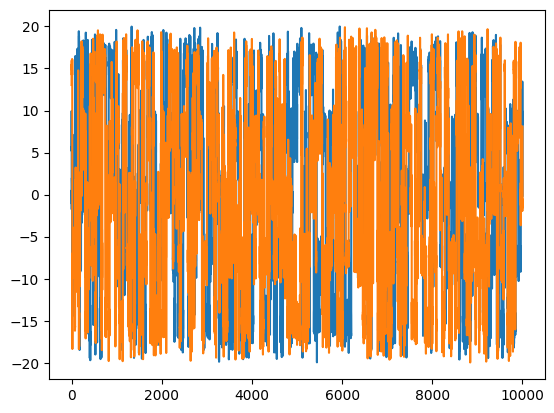

In [38]:
plt.plot(z);

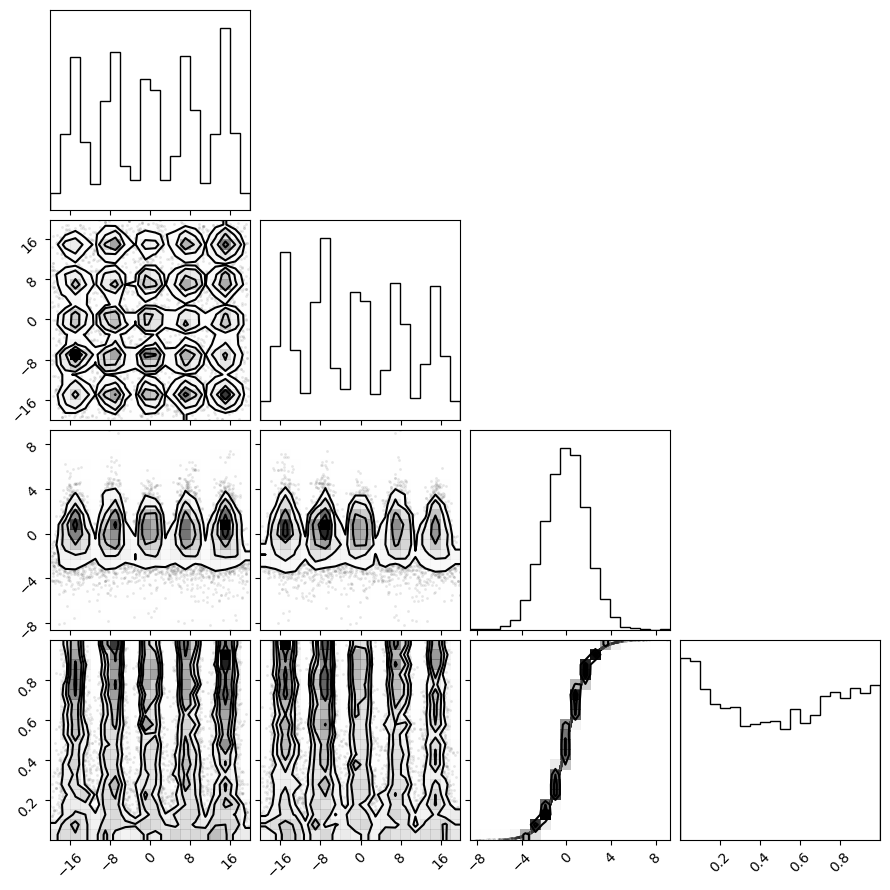

In [39]:
corner(np.transpose([*z.T, u, beta(u)]));

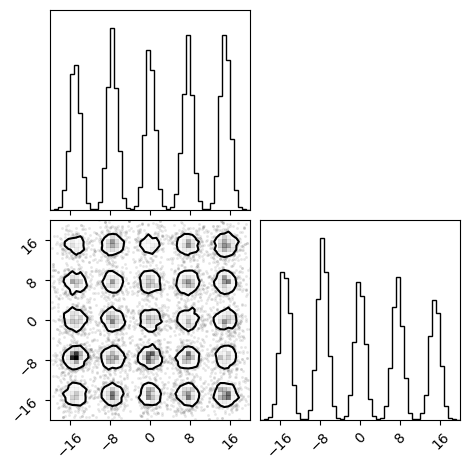

In [41]:
corner(
    np.array(z),
    weights = weights,
    range = [[-20, 20]] * 2,
    bins = 50,
    levels = (0.9,),
);